# Task 1: Resources (10 Points) 
Assuming you are not familiar with the framework, in this part of the 
homework you will present your research describing the resources you used to learn the 
framework (must include links to all resources). Clearly explain why you needed a particular 
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of 
all the computations in a NN i.e., what libraries/tools do you need within this framework.)

## My resources

My Framework:
* I decided to use the pytorch machine learning framework as the core driver of my project. The main reason I selected pytorch for this project its its growing use in academia (https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2022/) as well as its more user friendly API and less steep learning curve compared to Tensorflow (I have used both before). Despite already knowing pytorch, I used this as an opportunity to brush up on some of the finer details. The following resources were particularly helpful for general overview:
    * (https://pytorch.org/tutorials/beginner/basics/intro.html)
    * (https://towardsdatascience.com/intro-to-pytorch-part-1-663574fb9675)

For more specific questions about each part, I made heavy use of the documentation and Q&A boards to help guide me in the right direction while implementing my 2 layer NN:

Forward Pass:
* I need linear layers to act as the backbone of the network, giving me the actual "neurons" on each layer (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
* I need to use the RELU function for activation on my hidden layers (https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* For the output layer I need to use the Softmax activation function since its optimal for classification tasks (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) Sigmoid isn't as good for classification tasks and should only be used if there are multiple true outputs for the network see (https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer). 
* To combine the layers together into a single cohesive model i use the Sequential container (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

Cost Function:
* For the cost function I researched for the optimal cost functions for my task of multi-class classification, and found that the ideal cost function is typically Cross Entropy Loss, (implemented in torch as `torch.nn.CrossEntropyLoss`  (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), however because I use Softmax as the activation function for the final layer of my network, I instead use mean squared error loss, implemented in torch as `nn.MSELoss` (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), which is simpler. More on the specifics of this in task 3 section 4. 

Backpropigation and optimization:
* (https://arxiv.org/abs/2007.14166) provided a good overview of some of the common optimization algorithms that can be used for simple tasks in NNs, it helped me decide on using Adam (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as my optimizer due to its slew of good features. 
* the follow was useful for investigating how backprop and the optimization loop can be implemented in torch:
    * (https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)
    * (https://pytorch.org/docs/stable/notes/autograd.html)
    * (https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

Metrics:
* Due to my dataset and our discussions in previous weeks, I settled on using F1 score as my primary metric for evaluating the network due to high class imbalance in the dataset and high cost of false negatives for the task at hand. I use Scikitlearn's implementation as Torch does not provide an implementation (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score)



# Task 2: Data & Implementation (60 Points)
Once you have figured the resources you need for the project, design, and 
implement your project. The project must include the following steps (it’s not limited to these 
steps): 
1. Exploratory Data Analysis (Can include data cleaning, visualization etc.) 
2. Perform a train-dev-test split. 
3. Implement forward propagation (clearly describe the activation functions and other 
hyper-parameters you are using). 
4. Compute the final cost function. 
5. Implement gradient descent (any variant of gradient descent depending upon your 
data and project can be used) to train your model. In this step it is up to you as someone 
in charge of their project to improvise using optimization algorithms (Adams, RMSProp 
etc.) and/or regularization.  
6. Present the results using the test set. 

NOTE: In this step, once you have implemented your 2-layer network you may increase and/or 
decrease the number of layers as part of the hyperparameter tuning process.

## Step 1: Problem, Dataset, Exploratory Data Analysis

For this work we select the [shuttle dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)) and its task of classifying what means of control should be employed while landing the space shuttle based on the 9 features are signals derived from radiator sensors and the time at which they happened. The dataset is already split for us initially so that there is a good distribution of features is maintained across the slit, but we will combine it first and re-split it with a validation set as well for step 2.

In [2]:
import pandas as pd

#create our column names
feature_names = [f"x_{i}" for i in range(9)]
col_names = feature_names + ["y"]

#get our split datasets
old_testing = pd.read_csv("./data/shuttle.trn", names=col_names, sep=" ")
old_training = pd.read_csv("./data/sat.tst", names=col_names, sep=" ")

#combine them into a single dataset for exploratory data analysis.
data = pd.concat([old_testing, old_training])

#print if we have any NaNs or nulls in the dataset
print("NaNs or Nulls present: " + str(data.isnull().values.any()))
data.head()

NaNs or Nulls present: False


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,y
0,50,21,77,0,28,0,27,48,22,2
1,55,0,92,0,0,26,36,92,56,4
2,53,0,82,0,52,-5,29,30,2,1
3,37,0,76,0,28,18,40,48,8,1
4,37,0,79,0,34,-26,43,46,2,1


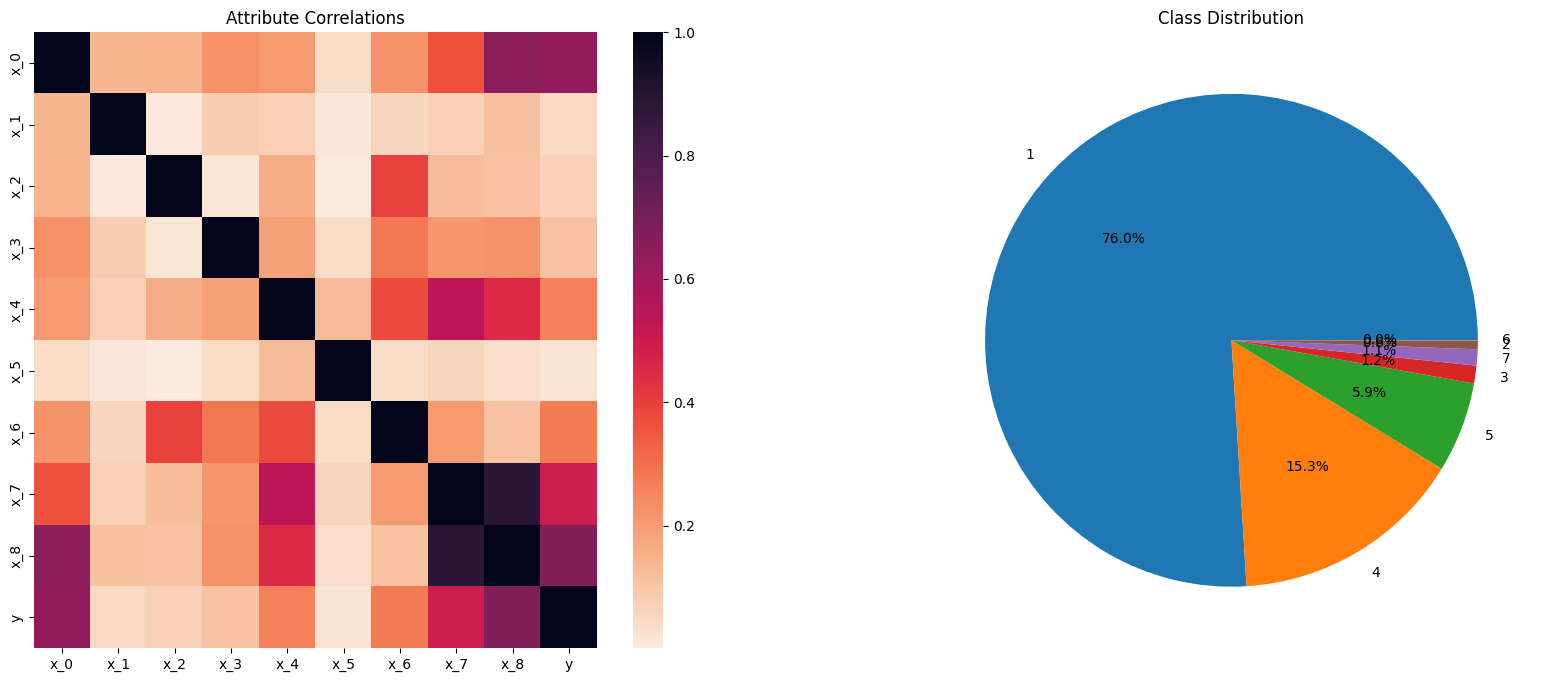

In [3]:
from turtle import title
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, figsize=(20,8))
#ax[0].imshow(data_raw.corr().abs(), cmap='rocket_r')
ax[0].set_title("Attribute Correlations")
sns.heatmap(data.corr().abs(),annot=False, ax=ax[0], cmap='rocket_r')
ax[1].set_title("Class Distribution")
ax[1].pie(x=data["y"].value_counts(), labels=data["y"].value_counts().index, autopct='%1.1f%%');

The corelation heatmap shows some medium corelation between our class and attributes 1 and 8, the rest have relatively low corelation. Our pie chart of class distribution shows a massive class imbalance, with class 1 composing nearly 80% of instances. This high imbalance, combined with stringent consequences for false negatives (millions of dollars of infrastructure are on the line for this decision problem), F1 score is the best metric for measuring performance on this task. 

## Step 2: Data split

When splitting the data, we need to ensure that our very specific class distribution is maintained to the very best of our ability. To ensure this, we use the `stratify` parameter in the `train_test_split` to provide class labels, which causes `train_test_split` to use `StratifiedShuffleSplit` on the backend which shuffles while maintaining even proportions of each class. 

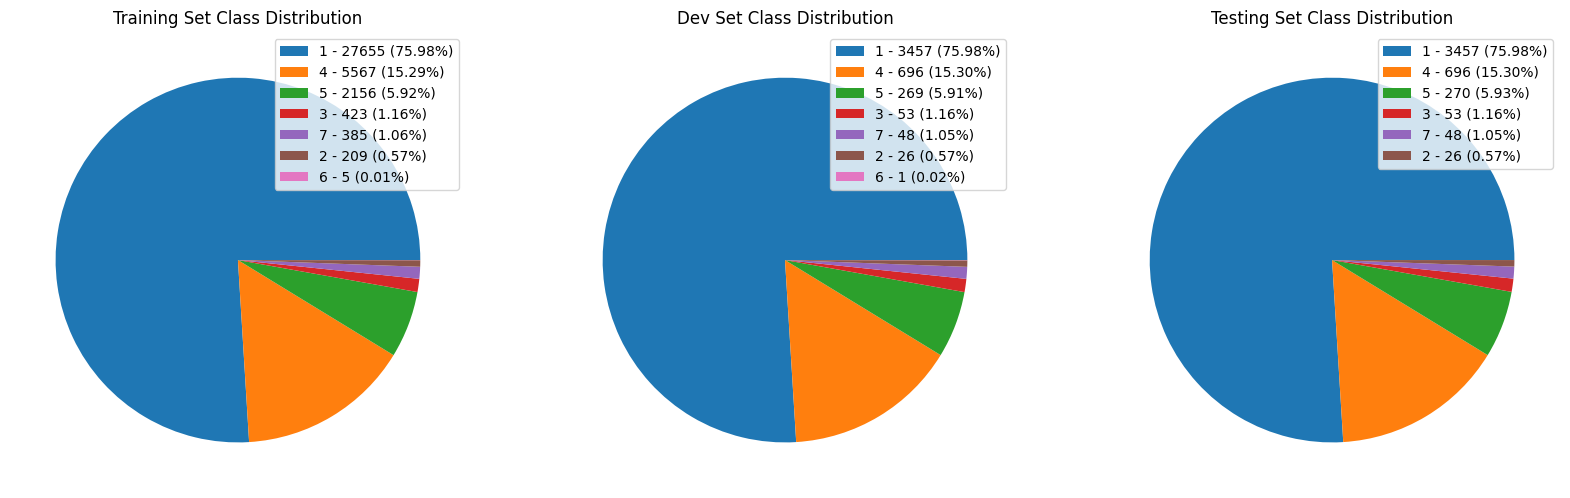

In [4]:
import math
import numpy as np
from sklearn.model_selection import train_test_split

training_percent = 0.8
testing_percent = 0.1
assert(0 < training_percent+testing_percent <= 1)
remainder_size = math.floor((training_percent+testing_percent) * data.shape[0])
testing_size = math.floor(testing_percent * data.shape[0])

x_dev, x_remainder, y_dev, y_remainder = train_test_split(data[feature_names], data["y"], test_size=remainder_size, stratify=data["y"])
x_train, x_test, y_train, y_test = train_test_split(x_remainder, y_remainder, test_size=testing_size, stratify=y_remainder)

#demonstrate our datasets have the same class distributions
fig, ax = plt.subplots(ncols=3, figsize=(20,8))

#plot a pie chart on the given axis breaking down the classes listed in the labels parameter
def pie_chart(axis_index, name, labels):
    unique_labels = np.transpose(np.unique(labels, return_counts=True))
    sorted_labels = np.transpose(unique_labels[unique_labels[:, 1].argsort()[::-1]])
    ax[axis_index].set_title(name + " Set Class Distribution")
    slices, texts = ax[axis_index].pie(sorted_labels[1]);
    pie_labels = [str(i) + " - {} ({:.2f}%)".format(j , 100*float(j/len(labels))) for i, j in  zip(sorted_labels[0], sorted_labels[1])]
    ax[axis_index].legend(slices, pie_labels)

pie_chart(0, "Training", y_train)
pie_chart(1, "Dev", y_dev)
pie_chart(2, "Testing", y_test)

We see that the split is successful in a broad sense, the only problem class being class 6 which doesn't really have enough examples in the dataset to be useful for us anyway.  

## Step 3: Implementing the forward pass

For the forward pass we define a custom model that takes a number of hidden layer widths and joins them with RELU activations. We use RELU since it is the arguably the best choice for hidden layer activation functions (see https://stats.stackexchange.com/questions/218752/relu-vs-sigmoid-vs-softmax-as-hidden-layer-neurons). For our final layer we use Softmax which is a better choice as output activation function than sigmoid for multi-class classification problems, however it does prevent us from using cross entropy loss for our cost function in step 4, due to the way pytorch structures their implementation. We stack our layers into a `torch.nn.Sequential` model and use the built in forward pass it provides to go through our layers, also this will be very useful when implementing gradient decent in step 5. 

In [20]:
import torch.nn as nn

class MyModel:

    #layer_widths is an array with the widths of each hidden layer in our network
    #layer_widths[0] is the input size and does not correspond to a hidden layer
    #layer_widths[-1] is the output shape and corresponds to the final layer
    def __init__(self, layer_widths):
        self.layer_widths = layer_widths
        assert len(layer_widths) >= 2, "Must have at least input size and output size"
        
        #For each hidden layer we create a linear layer with the given width and use RELU as the activation function
        self.layers = []
        for i in len(1, len(layer_widths)-1):
            self.layers.append(nn.Linear(layer_widths[i - 1], layer_widths[i]))
            self.layers.append(nn.ReLU())

        #For the final layer we use softmax since it is better than sigmoid for classification problems
        self.layers.append(nn.Linear(layer_widths[-2], layer_widths[-1]))
        self.layers.append(nn.Softmax())

        #create the model 
        self.model = nn.Sequential(*self.layers)

    # X is the input tensor of features, returns the value
    def forward_pass(self, X):
        return self.model(X)


## Step 4: Computing final cost function

For the cost function, I use mean squared error loss (implemented in torch as `nn.MSELoss`) which is one of the two dominant loss functions for multi-class classification tasks. The other potential option here was Cross Entropy Loss (implemented in torch as `torch.nn.CrossEntropyLoss`), however as previously mentioned, because I use Softmax as the activation function for the final layer of my network, this is not allowed in torches implementation. I could have used negative log likelihood loss (implemented as `torch.nn.NLLLoss`) to get the same result as cross entropy loss, but decided against this and to keep things simple with MSE. 

In [ ]:

def cost(output, labels):
    #I use MSE Loss rather than cross entropy loss because I'm already using softmax and you're not supposed to use softmax a cross entropy loss in pytorch
    #https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch
    lossFunction = nn.MSELoss() 
    return lossFunction(output, labels)

## Step 5: Implement gradient descent (and main training loop)

# Task 3: Hyperparameter Justification (10 Points)
In task 2 describe how you selected the hyperparameters. What was the 
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use 
an optimization algorithm? Why or why not?

# Task 4: Baseline Comparison (20 Points)
Create another baseline model (can be any model we covered so far except a 
deep learning model). Using the same training data (as above) train your model and evaluate 
results using the test set. Compare the results of both models (the Neural Network and the 
baseline model). What are the reasons for one model performing better (or not) than the 
other? Explain.